# 0. Libraries

In [1]:
!pip install skrebate
!pip install imbalanced-learn

  Created wheel for skrebate: filename=skrebate-0.61-cp36-none-any.whl size=29257 sha256=2e6f05cf4cb314df85a1c5e3a01c4ec79bfbf7922a6236abe614acbac18273a2
  Stored in directory: /root/.cache/pip/wheels/ae/d8/ae/9b51d487e9d02219996d6c260255a216ef07d905b0a0b00ce3
Successfully built skrebate


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from skrebate import ReliefF
import seaborn as sns

from sklearn.feature_selection import GenericUnivariateSelect, SelectKBest, mutual_info_classif, f_classif, RFE, RFECV
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict, cross_val_score, validation_curve, GridSearchCV, StratifiedKFold, ShuffleSplit
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, plot_roc_curve, roc_auc_score
from imblearn.combine import SMOTEENN

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

Using TensorFlow backend.


# 1. Descriptive analysis

First, we load the data and store it into a DataFrame

In [2]:
df = pd.read_csv('data.csv')
df.head()

quality  bits  intra_parts  skip_parts  inter_16x16_parts  inter_4x4_parts  \
0       22  2143            0           0                  1                3   
1       22  1735            0           2                  0                3   
2       22  1971            0           0                  0                0   
3       22  2473            0           0                  0               18   
4       22  1093            0           0                  1                3   

   inter_other_parts  non_zero_pixels  frame_width  frame_height  ...  \
0                 21              404          416           240  ...   
1                  8              381          416           240  ...   
2                  8              460          416           240  ...   
3                 20              421          416           240  ...   
4                  8              167          416           240  ...   

     sobel_h    sobel_v    variance  block_movement_h  block_movement_v  \
0  17.397461  17.397461   87.584335          2.820312          2.539062   
1  14.426758  14.233398   48.025330          1.843750          1.921875   
2  15.203125  13.953125   56.613480          3.000000          4.937500   
3  21.725586  29.165039  283.079285          2.078125          2.500000   
4  11.929688  14.353516  175.123245          3.070312          4.523438   

   var_movement_h  var_movement_v   cost_1   cost_2  relevant  
0       10.772400        8.576599      0.0      0.0       1.0  
1        6.163086        6.665771   8816.0   8801.0       1.0  
2        1.625000        3.683594   5104.0   5193.0       1.0  
3       25.806396       34.656250  21531.0  19802.0       1.0  
4       22.252869       14.780701  15073.0  14549.0       1.0  

[5 rows x 27 columns]

Now we can perform some exploratory analysis about the shape, the type of information each variable contains...

The raw dataframe has 16000 observations and 27 variables

In [3]:
df.shape

(16000, 27)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   quality            16000 non-null  int64  
 1   bits               16000 non-null  int64  
 2   intra_parts        16000 non-null  int64  
 3   skip_parts         16000 non-null  int64  
 4   inter_16x16_parts  16000 non-null  int64  
 5   inter_4x4_parts    16000 non-null  int64  
 6   inter_other_parts  16000 non-null  int64  
 7   non_zero_pixels    16000 non-null  int64  
 8   frame_width        16000 non-null  int64  
 9   frame_height       16000 non-null  int64  
 10  movement_level     16000 non-null  int64  
 11  mean               16000 non-null  float64
 12  sub_mean_1         16000 non-null  float64
 13  sub_mean_2         16000 non-null  float64
 14  sub_mean_3         15986 non-null  float64
 15  sub_mean_4         16000 non-null  float64
 16  var_sub_blocks     160

Data dictionary

1. **quality**: a measure of the quality of the recorded video.
2. **bits**: number of bits used to encode that block in the video stream.
3. **intra_parts**: number sub-blocks inside this block that are not encoded by making use of information in other frames.
4. **skip_parts**: number sub-blocks inside this block that are straight-forward copied from another frame.
5. **inter_16x16_parts**: number of sub-blocks inside this block making use of information in other frames and whose size is 16x16 pixels.
6. **inter_4x4_parts**: number of sub-blocks inside this block making use of information in other frames and whose size is 4x4 pixels.
7. **inter_other_parts**: number of sub-blocks inside this block making use of information in other frames and whose size is different from 16x16 and 4x4 pixels.
8. **non_zero_pixels**: number of pixels different from 0 after encoding the block.
9. **frame_width**: the width of the video frame in pixels.
10. **frame_height**: the height of the video frame in pixels.
11. **movement_level**: a measure of the level of movement of this frame with respect the previous one.
12. **mean**: mean of the pixels of the encoded block.
13. **sub_mean_1**: mean of the pixels contained in the first 32x32 sub-bock of the current block.
14. **sub_mean_2**: mean of the pixels contained in the second 32x32 sub-bock of the current block.
15. **sub_mean_3**: mean of the pixels contained in the third 32x32 sub-bock of the current block.
16. **sub_mean_4**: mean of the pixels contained in the fourth 32x32 sub-bock of the current block.
17. **var_sub_blocks**: variance of the four previous values.
18. **sobel_h**: mean of the pixels of the encoded block after applying the Sobel operator in horizontal direction.
19. **sobel_v**: mean of the pixels of the encoded block after applying the Sobel operator in vertical direction.
20. **variance**: variance of the pixels of the encoded block.
21. **block_movement_h**: a measure of the movement of the current block in the horizontal direction.
22. **block_movement_v**: a measure of the movement of the current block in the vertical direction.
23. **var_movement_h**: a measure of the variance of the movements inside the current block in the horizontal direction.
24. **var_movement_v**: a measure of the variance of the movements inside the current block in the vertical direction.
25. **cost_1**: a measure of the cost of encoding this block without partitioning it.
26. **cost_2**: a measure of the cost of encoding this block without partitioning it and withoutconsidering any movement in it.
27. **relevant**: the target variable that indicates whether the current block is relevant (1) or not (0).

In [5]:
df.nunique()

quality                  4
bits                  2106
intra_parts             15
skip_parts               5
inter_16x16_parts        5
inter_4x4_parts         12
inter_other_parts       28
non_zero_pixels        568
frame_width              4
frame_height             4
movement_level         205
mean                  6599
sub_mean_1            3123
sub_mean_2            3022
sub_mean_3            3072
sub_mean_4            2975
var_sub_blocks       11457
sobel_h               9908
sobel_v               9896
variance             12001
block_movement_h      2368
block_movement_v      2221
var_movement_h        8427
var_movement_v        8450
cost_1               14378
cost_2               14538
relevant                 2
dtype: int64

The following are some of the most relevant statistics for each of the attributes covered by the dataset: mean, median, standard deviation, maximum and minimum values and percentiles

In [6]:
df.describe()

quality          bits   intra_parts    skip_parts  \
count  16000.000000  16000.000000  16000.000000  16000.000000   
mean      29.500000    449.837312     11.040000      0.849187   
std        5.590345    549.338243     19.050616      1.181855   
min       22.000000      0.000000      0.000000      0.000000   
25%       25.750000     72.000000      0.000000      0.000000   
50%       29.500000    243.000000      0.000000      0.000000   
75%       33.250000    622.000000     16.000000      1.000000   
max       37.000000   4771.000000     64.000000      4.000000   

       inter_16x16_parts  inter_4x4_parts  inter_other_parts  non_zero_pixels  \
count       16000.000000     16000.000000       16000.000000     16000.000000   
mean            0.995437         1.978687           3.686437        74.087125   
std             1.018507         3.901610           4.446710       102.640728   
min             0.000000         0.000000           0.000000         0.000000   
25%             0.000000         0.000000           0.000000         5.000000   
50%             1.000000         0.000000           2.000000        33.000000   
75%             2.000000         3.000000           6.000000       100.000000   
max             4.000000        33.000000          27.000000       828.000000   

        frame_width  frame_height  ...       sobel_h       sobel_v  \
count  16000.000000  16000.000000  ...  16000.000000  16000.000000   
mean    1432.000000    850.000000  ...      8.027763      8.271249   
std      851.904548    530.205215  ...      9.184907      9.552508   
min      416.000000    240.000000  ...      0.000000      0.000000   
25%      728.000000    420.000000  ...      0.897705      0.943359   
50%     1376.000000    780.000000  ...      5.171387      5.313477   
75%     2080.000000   1210.000000  ...     11.629883     11.776611   
max     2560.000000   1600.000000  ...     69.706055     66.775391   

           variance  block_movement_h  block_movement_v  var_movement_h  \
count  16000.000000      16000.000000      16000.000000    16000.000000   
mean      53.332864          8.023825          6.797076      841.948320   
std      107.265796         17.259731         11.552299     3815.230446   
min        0.000000          0.000000          0.000000        0.000000   
25%        1.424867          0.500000          0.500000        0.687500   
50%       14.525076          2.625000          3.210938       11.683594   
75%       52.498296          7.062500          8.062500       94.025574   
max     2022.197998        322.093750        189.000000   194634.750000   

       var_movement_v         cost_1         cost_2      relevant  
count    16000.000000   16000.000000   15983.000000  15998.000000  
mean       491.913447   36948.640625   42059.829569      0.822353  
std       2404.069505   38631.383338   43844.708679      0.382227  
min          0.000000       0.000000       0.000000      0.000000  
25%          0.746094    9916.750000   10965.000000      1.000000  
50%         19.527344   23051.500000   26135.000000      1.000000  
75%         96.064392   52071.250000   59876.500000      1.000000  
max      68389.359375  425705.000000  446306.000000      1.000000  

[8 rows x 27 columns]

# 2. Data exploration

We have to check whether the dataframe contains null values or not. For this task we will order the attributes in a descendent order of the number of null values. As it is shown, we have 33 null values distributed between three variables: *cost_2*, *sub_mean_3* and *relevant*. 

In [7]:
df.isnull().sum().sort_values(ascending=False)

cost_2               17
sub_mean_3           14
relevant              2
mean                  0
bits                  0
intra_parts           0
skip_parts            0
inter_16x16_parts     0
inter_4x4_parts       0
inter_other_parts     0
non_zero_pixels       0
frame_width           0
frame_height          0
movement_level        0
sub_mean_2            0
sub_mean_1            0
sub_mean_4            0
var_sub_blocks        0
sobel_h               0
sobel_v               0
variance              0
block_movement_h      0
block_movement_v      0
var_movement_h        0
var_movement_v        0
cost_1                0
quality               0
dtype: int64

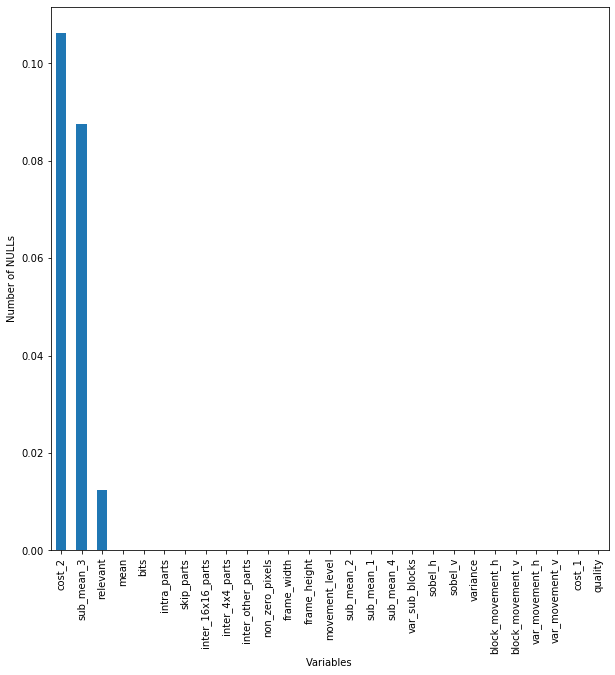

In [8]:
((df.isnull().sum()/df.shape[0])*100).sort_values(ascending=False).plot(kind='bar', figsize=(10,10))
plt.xlabel('Variables')
plt.ylabel('Number of NULLs')
plt.show()

One option to deal with null values is replacing them with the mean of the attribute, but as the total amount of observations is large (16000), omitting the observations that have missing values will not make any significant change in the results, so we decided to do it in this last way. 

In [3]:
df.dropna(inplace=True)

Let's check if everything is okey by repeating the order of the above command

In [10]:
df.isnull().sum().sort_values(ascending=False)

relevant             0
sub_mean_1           0
bits                 0
intra_parts          0
skip_parts           0
inter_16x16_parts    0
inter_4x4_parts      0
inter_other_parts    0
non_zero_pixels      0
frame_width          0
frame_height         0
movement_level       0
mean                 0
sub_mean_2           0
cost_2               0
sub_mean_3           0
sub_mean_4           0
var_sub_blocks       0
sobel_h              0
sobel_v              0
variance             0
block_movement_h     0
block_movement_v     0
var_movement_h       0
var_movement_v       0
cost_1               0
quality              0
dtype: int64

## 2.1 Feature distribution

Let's see a first approximation about the distribution of the variables and the existing relationship between them

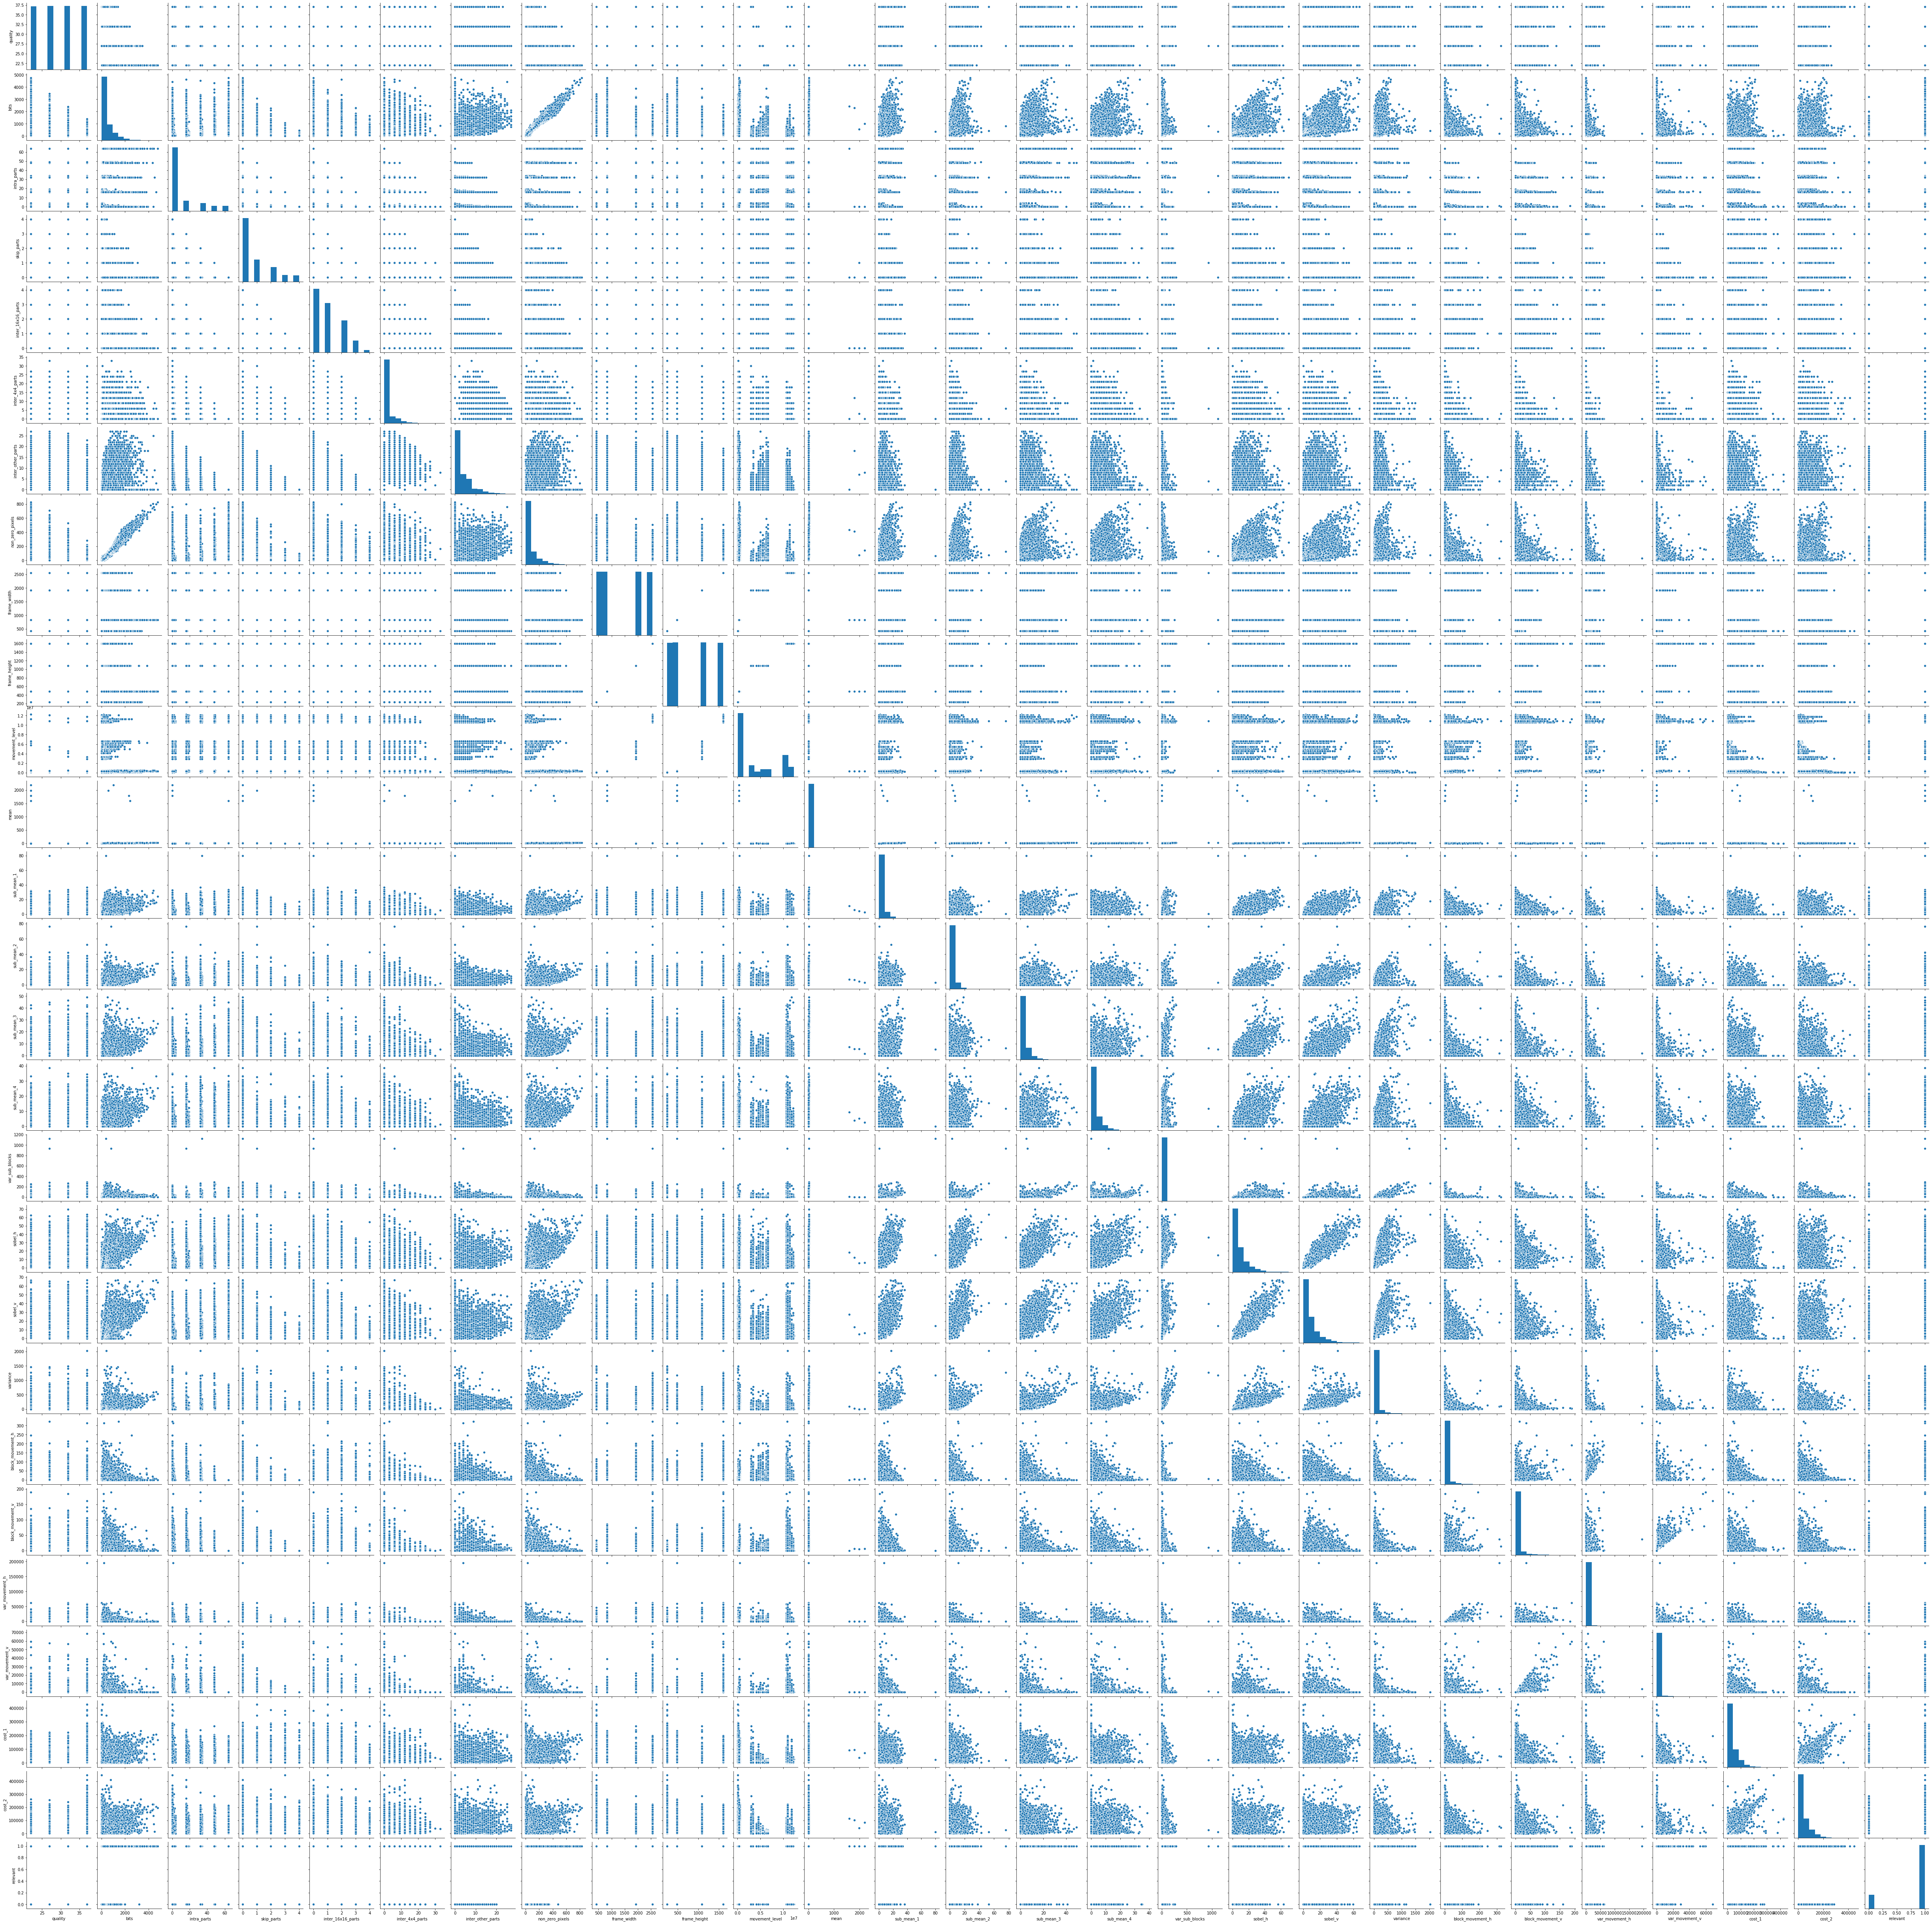

In [11]:
sns.pairplot(df, palette = 'Set1')

Due to the values that each of the variables can take, we distinguish between categorical and numerical variables

In [5]:
categorical_variables = ['quality','skip_parts','inter_16x16_parts','inter_4x4_parts','frame_width','frame_height','relevant']
numerical_variables = ['bits','intra_parts','inter_other_parts','non_zero_pixels','movement_level','mean','sub_mean_1','sub_mean_2','sub_mean_3','sub_mean_4','var_sub_blocks','sobel_h','sobel_v','variance','block_movement_h','block_movement_v','var_movement_h','var_movement_v','cost_1','cost_2']

### 2.1.1 Numerical Features

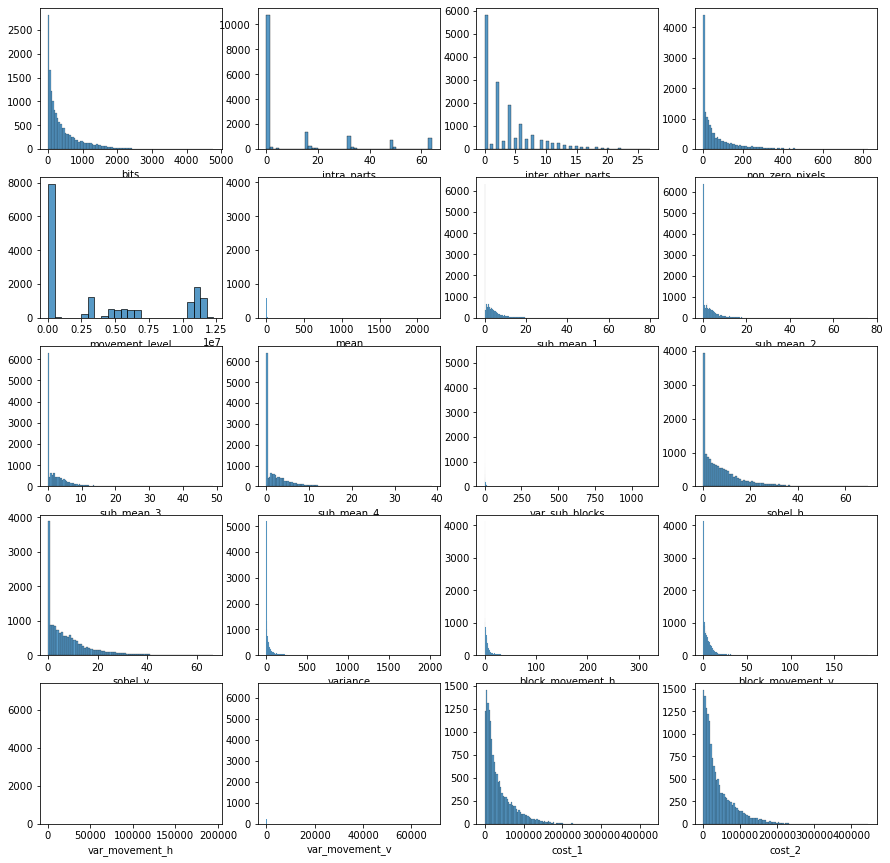

In [6]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15,15))

for ax, feat in zip(axes.flatten(), numerical_variables):
    sns.histplot(df, x=feat, ax=ax)
    ax.set(ylabel = '')

### 2.1.2 Categorical Features

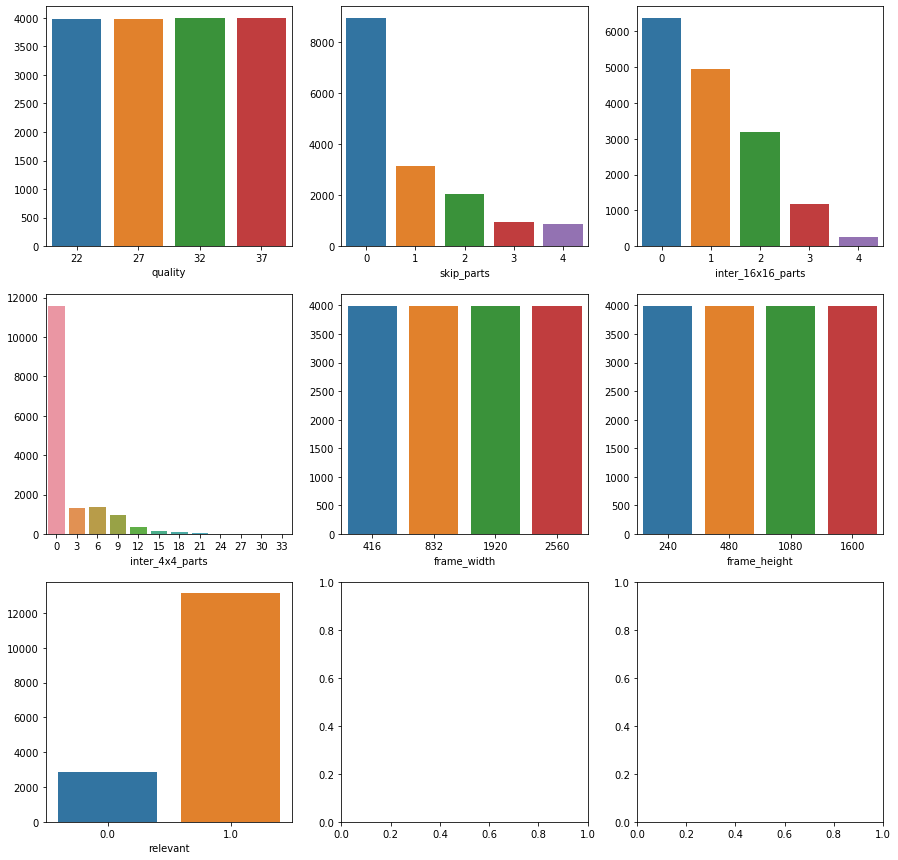

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,15))

for ax, feat in zip(axes.flatten(), categorical_variables):
    sns.countplot(data=df, x=feat, ax=ax)
    ax.set(ylabel = '')

### 2.1.3 Class Variable

The class variable is the one that refers to the relevancy of the image: relevant. We compute the percentage of observations in the clean dataset that are relevant ant the ones that are not. Due to the fact we have much more relevant observation than irrelevant ones, we will be working with an imbalanced dataset (82.23% vs 17.76%)

In [8]:
print('Percentage of Relevant observations: ',
      round(len(df[df['relevant']==1])/len(df['relevant'])*100,2),
      "%")
print('Percent of Irrelevant observations: ',
      round(len(df[df['relevant']==0])/len(df['relevant'])*100,2),
      "%")

Percentage of Relevant observations:  82.21 %
Percent of Irrelevant observations:  17.79 %


# 3. Data preparation

As detailed in the previous section, the existence of null values has been detected in some of the observations in the dataset. Given that this number of incomplete observations is not significant in comparison with the total set of observations, it has been decided to eliminate the records associated with these null values.

The next task will be to differentiate between the attributes or independent variables *X* and the dependent or output variable *Y*, which will be the ***relevant*** column. 

In [4]:
X = df.iloc[:, :26]
y = df.iloc[:, 26:]

Thanks to the analyses carried out previously, it has been possible to denote a clear case of imbalance in our dataset, since the number of observations categorised as *relevant* ('1'), are considerably more numerous than those *not relevant* (0): 82.23% vs 17.76%

In order to avoid possible biases in our data, we have chosen to use **SMOTE**. SMOTE is applied for oversampling and Edited Nearest Neighbours for undersampling

In [5]:
X_resample, y_resample = SMOTEENN(sampling_strategy=0.75, random_state=0).fit_resample(X, y)
y_resample.relevant.value_counts()

1.0    7298
0.0    5594
Name: relevant, dtype: int64

Finally, a common good practice in any data preparation task is to proceed with data standardization or scaling. This is because it is possible that, due to the units used in the measurement process, some of these may have an inadequate weight in the prediction of the output variable. In particular, it has been decided to choose the *MinMaxScaler* option and collect all possible values in a closed interval between 0 and 1: [0,1]



In [6]:
X = pd.DataFrame(data=MinMaxScaler(feature_range=(0, 1)).fit_transform(X), columns=X.columns)
X_resample = pd.DataFrame(MinMaxScaler(feature_range=(0, 1)).fit_transform(X_resample), columns=X_resample.columns)

## 3.1 Feature subset selection

Then, feature subset selection techniques were performed in order to get rid of useless features and find the most important ones.

### 3.1.1 Univariate filter (Mutual Information)

In [37]:
#Mutual Information
scores = np.zeros(26)
for i in range(0,10):
    test = SelectKBest(score_func=mutual_info_classif, k=5)
    fit = test.fit(X_resample, np.ravel(y_resample))
    scores = [(x + y) for x, y in zip(scores, fit.scores_)]

scores = [x/10 for x in scores]
# Summarize scores
scores = pd.DataFrame(data=scores,index=X.columns, columns=['Scores'])
scores = scores.sort_values(by='Scores', ascending=False)
print("Univariate Filter (Mutual Information)")
print(scores)

Univariate Filter (Mutual Information)
                     Scores
movement_level     0.295950
bits               0.223665
non_zero_pixels    0.203577
quality            0.139715
inter_other_parts  0.135319
block_movement_h   0.131791
sub_mean_4         0.128495
block_movement_v   0.125625
intra_parts        0.122675
sobel_v            0.119004
sobel_h            0.118511
sub_mean_3         0.112632
mean               0.111623
sub_mean_2         0.106402
inter_4x4_parts    0.102599
sub_mean_1         0.099245
frame_height       0.098375
frame_width        0.098214
skip_parts         0.078376
variance           0.076558
cost_2             0.062095
cost_1             0.054589
var_sub_blocks     0.043594
var_movement_v     0.037041
var_movement_h     0.035732
inter_16x16_parts  0.004814


In [7]:
X_MI = X_resample[['bits','movement_level','non_zero_pixels']]

### 3.1.2 Multivariate filter (Relief)

In [36]:
#Relief
fs = ReliefF()
fs.fit(np.array(X_resample), np.concatenate(np.array(y_resample)))
    
scores = pd.DataFrame(data=fs.feature_importances_,index=X.columns, columns=['Scores'])
scores = scores.sort_values(by='Scores', ascending=False)
print("Multivariate Filter (Relief)")
print(scores)

Multivariate Filter (Relief)
                     Scores
quality            0.143928
inter_16x16_parts  0.114372
bits               0.103440
non_zero_pixels    0.095010
frame_width        0.084594
frame_height       0.084594
skip_parts         0.077872
cost_1             0.062004
cost_2             0.061040
sobel_h            0.054677
sobel_v            0.053490
intra_parts        0.050236
inter_other_parts  0.049930
inter_4x4_parts    0.040114
sub_mean_4         0.035281
movement_level     0.026938
sub_mean_2         0.022412
block_movement_h   0.022110
sub_mean_3         0.021937
sub_mean_1         0.021437
block_movement_v   0.018757
variance           0.017149
var_movement_h     0.009857
var_movement_v     0.004920
var_sub_blocks     0.003925
mean               0.000157


In [8]:
X_Relief = X_resample[['quality','inter_16x16_parts','bits','non_zero_pixels']]

# 4. Model learning

In [9]:
kf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
def showResults(model, X, y):
    results = cross_validate(model, X, y, scoring = ['accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted', 'roc_auc'], cv = kf)
    print(str(model.__class__.__name__) + ":")
    print('\t- Accuracy: \t' + str(results['test_accuracy'].mean()))
    print('\t- Precision: \t' + str(results['test_precision_weighted'].mean()))
    print('\t- Recall: \t' + str(results['test_recall_weighted'].mean()))
    print('\t- F1: \t\t' + str(results['test_f1_weighted'].mean()))
    print('\t- ROC_AUC: \t' + str(results['test_roc_auc'].mean()))

## 4.1 SVM

In [ ]:
param_grid = {
    'kernel': ['rbf'],
    'gamma': ['scale', 'auto'],
    'C': [0.1, 1],
}
grid_search = GridSearchCV(SVC(random_state=0), param_grid, cv=kf)
grid_search.fit(X, np.ravel(y))
grid_search.best_params_

{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

In [ ]:
param_grid = {
    'kernel': ['rbf'],
    'gamma': ['scale', 'auto'],
    'C': [0.1, 1],
}
grid_search = GridSearchCV(SVC(random_state=0), param_grid, cv=kf)
grid_search.fit(X_resample, np.ravel(y_resample))
grid_search.best_params_

{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

In [50]:
print(showResults(SVC(random_state=0), X, np.ravel(y)))
print(showResults(SVC(random_state=0), X_resample, np.ravel(y_resample)))
print(showResults(SVC(random_state=0), X_MI, np.ravel(y_resample)))
print(showResults(SVC(random_state=0), X_Relief, np.ravel(y_resample)))

C:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC:
	- Accuracy: 	0.8235738164711826
	- Precision: 	0.7593949049915073
	- Recall: 	0.8235738164711826
	- F1: 		0.7618511677232875
	- ROC_AUC: 	0.7190430143284219
None
SVC:
	- Accuracy: 	0.8796148758953306
	- Precision: 	0.8796701184162947
	- Recall: 	0.8796148758953306
	- F1: 		0.8791924319512324
	- ROC_AUC: 	0.9430002541302602
None
SVC:
	- Accuracy: 	0.8060811633979889
	- Precision: 	0.8084503383343054
	- Recall: 	0.8060811633979889
	- F1: 		0.8033294435607476
	- ROC_AUC: 	0.8645627602440529
None
SVC:
	- Accuracy: 	0.7914212513735847
	- Precision: 	0.7978347498671219
	- Recall: 	0.7914212513735847
	- F1: 		0.7923033770965505
	- ROC_AUC: 	0.8626268979312555
None


## 4.2 Naive Bayes

In [47]:
print(showResults(GaussianNB(), X, np.ravel(y)))
print(showResults(GaussianNB(), X_resample, np.ravel(y_resample)))
print(showResults(GaussianNB(), X_MI, np.ravel(y_resample)))
print(showResults(GaussianNB(), X_Relief, np.ravel(y_resample)))

GaussianNB:
	- Accuracy: 	0.5213878747361607
	- Precision: 	0.8145537107155982
	- Recall: 	0.5213878747361607
	- F1: 		0.5677043667433205
	- ROC_AUC: 	0.7425238484987239
None
GaussianNB:
	- Accuracy: 	0.7147063273783507
	- Precision: 	0.7681860642458671
	- Recall: 	0.7147063273783507
	- F1: 		0.7107623620735444
	- ROC_AUC: 	0.8489175702096302
None
GaussianNB:
	- Accuracy: 	0.7249454100689732
	- Precision: 	0.7964993520077188
	- Recall: 	0.7249454100689732
	- F1: 		0.7187639330553128
	- ROC_AUC: 	0.864054994506108
None
GaussianNB:
	- Accuracy: 	0.7375110962175548
	- Precision: 	0.8004185431482111
	- Recall: 	0.7375110962175548
	- F1: 		0.7330192099434273
	- ROC_AUC: 	0.8549937462983852
None


## 4.3 Decision Tree

In [ ]:
param_grid = { 
    'max_depth' :[5,6,7,8,9,10],
    'criterion' :['gini','entropy'],
}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state = 0, splitter='best'), param_grid, cv=kf)
grid_search.fit(X, np.ravel(y))
grid_search.best_params_

{'criterion': 'entropy', 'max_depth': 5}

In [ ]:
param_grid = { 
    'max_depth' :[5,6,7,8,9,10],
    'criterion' :['gini','entropy'],
}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state = 0, splitter='best'), param_grid, cv=kf)
grid_search.fit(X_resample, np.ravel(y_resample))
grid_search.best_params_

{'criterion': 'gini', 'max_depth': 10}

In [11]:
print(showResults(DecisionTreeClassifier(random_state = 0, splitter='best', max_depth=5, criterion='entropy'), X, np.ravel(y)))
print(showResults(DecisionTreeClassifier(random_state = 0, splitter='best', max_depth=10, criterion='gini'), X_resample, np.ravel(y_resample)))
print(showResults(DecisionTreeClassifier(random_state = 0, splitter='best', max_depth=10, criterion='gini'), X_MI, np.ravel(y_resample)))
print(showResults(DecisionTreeClassifier(random_state = 0, splitter='best', max_depth=10, criterion='gini'), X_Relief, np.ravel(y_resample)))

DecisionTreeClassifier:
	- Accuracy: 	0.8270181464972788
	- Precision: 	0.7900848182175991
	- Recall: 	0.8270181464972788
	- F1: 		0.7853985213371192
	- ROC_AUC: 	0.771004853520588
None
DecisionTreeClassifier:
	- Accuracy: 	0.8710817905918514
	- Precision: 	0.8718339806484734
	- Recall: 	0.8710817905918514
	- F1: 		0.8712068639474986
	- ROC_AUC: 	0.9077701667117009
None
DecisionTreeClassifier:
	- Accuracy: 	0.8174065699233921
	- Precision: 	0.8177497978324176
	- Recall: 	0.8174065699233921
	- F1: 		0.8173669460850126
	- ROC_AUC: 	0.8847512178289764
None
DecisionTreeClassifier:
	- Accuracy: 	0.7947571406096445
	- Precision: 	0.7966363802568829
	- Recall: 	0.7947571406096445
	- F1: 		0.7952539844777384
	- ROC_AUC: 	0.8622927564287604
None


## 4.4 Random Forest

In [ ]:
param_grid = { 
    'n_estimators' :[25,50,75,100],
    'max_depth' :[5,6,7,8,9,10],
    'criterion' :['gini','entropy'],
}
grid_search = GridSearchCV(RandomForestClassifier(random_state = 0), param_grid, cv=kf)
grid_search.fit(X, np.ravel(y))
grid_search.best_params_

{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100}

In [ ]:
param_grid = { 
    'n_estimators' :[25,50,75,100],
    'max_depth' :[5,6,7,8,9,10],
    'criterion' :['gini','entropy'],
}
grid_search = GridSearchCV(RandomForestClassifier(random_state = 0), param_grid, cv=kf)
grid_search.fit(X_resample, np.ravel(y_resample))
grid_search.best_params_

{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100}

In [49]:
print(showResults(RandomForestClassifier(random_state=0, max_depth=10, criterion='gini'), X, np.ravel(y)))
print(showResults(RandomForestClassifier(random_state=0, max_depth=10, criterion='gini'), X_resample, np.ravel(y_resample)))
print(showResults(RandomForestClassifier(random_state=0, max_depth=10, criterion='gini'), X_MI, np.ravel(y_resample)))
print(showResults(RandomForestClassifier(random_state=0, max_depth=10, criterion='gini'), X_Relief, np.ravel(y_resample)))

RandomForestClassifier:
	- Accuracy: 	0.8317151580604175
	- Precision: 	0.8002639316767894
	- Recall: 	0.8317151580604175
	- F1: 		0.7907082281185831
	- ROC_AUC: 	0.7997107681571209
None
RandomForestClassifier:
	- Accuracy: 	0.90079062524159
	- Precision: 	0.9007374478095848
	- Recall: 	0.90079062524159
	- F1: 		0.9007370819898426
	- ROC_AUC: 	0.9652396769527736
None
RandomForestClassifier:
	- Accuracy: 	0.8340051276482396
	- Precision: 	0.8336953352904899
	- Recall: 	0.8340051276482396
	- F1: 		0.8334704459103474
	- ROC_AUC: 	0.9174913985313905
None
RandomForestClassifier:
	- Accuracy: 	0.8170189129782803
	- Precision: 	0.8187683243944688
	- Recall: 	0.8170189129782803
	- F1: 		0.8174725091955748
	- ROC_AUC: 	0.895097880737131
None


## 4.5 AdaBoost

In [45]:
print(showResults(AdaBoostClassifier(DecisionTreeClassifier(random_state = 0, splitter='best', max_depth=5, criterion='entropy'), random_state=0), X, np.ravel(y)))
print(showResults(AdaBoostClassifier(DecisionTreeClassifier(random_state = 0, splitter='best', max_depth=10, criterion='gini'), random_state=0), X_resample, np.ravel(y_resample)))
print(showResults(AdaBoostClassifier(DecisionTreeClassifier(random_state = 0, splitter='best', max_depth=10, criterion='gini'), random_state=0), X_MI, np.ravel(y_resample)))
print(showResults(AdaBoostClassifier(DecisionTreeClassifier(random_state = 0, splitter='best', max_depth=10, criterion='gini'), random_state=0), X_Relief, np.ravel(y_resample)))

AdaBoostClassifier:
	- Accuracy: 	0.7978321786798415
	- Precision: 	0.7782826368983463
	- Recall: 	0.7978321786798415
	- F1: 		0.786322811546475
	- ROC_AUC: 	0.7169113786912318
None
AdaBoostClassifier:
	- Accuracy: 	0.9290252685427534
	- Precision: 	0.9292441773357396
	- Recall: 	0.9290252685427534
	- F1: 		0.929084718756711
	- ROC_AUC: 	0.9789550246299965
None
AdaBoostClassifier:
	- Accuracy: 	0.817871896631232
	- Precision: 	0.8177361352049873
	- Recall: 	0.817871896631232
	- F1: 		0.8177761795869409
	- ROC_AUC: 	0.8919461115039811
None
AdaBoostClassifier:
	- Accuracy: 	0.7733488331938065
	- Precision: 	0.7747868192446875
	- Recall: 	0.7733488331938065
	- F1: 		0.7737905905511402
	- ROC_AUC: 	0.8466780969829848
None
